In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm

# Set the parameters

In [2]:
K=100.0
T=1.0
S=100.0
sig=0.2
r=0.06
div=0.03
N=300 # Number of time steps
M=100000 # Number of simulations

# Find the derived parameters

In [3]:
def findBasicParameters(K,T,S,sig,r,div,N,M,printer=False):
    dt=T/N
    nudt=(r-div-0.5*sig*sig)*dt
    sigsdt=sig*np.sqrt(dt)
    lnS=np.log(S)
    erddt=np.exp((r-div)*dt)
    if printer:     
        print "dt",dt
        print "nudt",nudt
        print "sigsdt",sigsdt
        print "lnS",lnS
        print "Number of simulations M",M
        print "Number of time steps N",N
        print "erddt",erddt
    numOfTimeSteps = np.arange(N)
    numOfSimulatioms = np.arange(M)
    return (dt,nudt,sigsdt,lnS,erddt,numOfTimeSteps,numOfSimulatioms)
    
(dt,nudt,sigsdt,lnS,erddt,numOfTimeSteps,numOfSimulatioms)=findBasicParameters(K,T,S,sig,r,div,N,M,printer=True)

dt 0.00333333333333
nudt 3.33333333333e-05
sigsdt 0.0115470053838
lnS 4.60517018599
Number of simulations M 100000
Number of time steps N 300
erddt 1.000100005


# Simple Monte Carlo Pricing

In [408]:
def findOptionPriceMonteCarlo(K,T,S,sig,r,div,N,M,optionType,printer=False):
    startMC= pd.datetime.now()
    if(optionType=="c"):
        optionFlag=1
    elif(optionType=="p"):
        optionFlag=-1
    sum_CT=0
    sum_CT2=0
    (dt,nudt,sigsdt,lnS,erddt,numOfTimeSteps,numOfSimulatioms)=findBasicParameters(K,T,S,sig,r,div,N,M,printer=printer)  
    for x in np.nditer(numOfSimulatioms, order='F'):
        #print j
        lnSt=lnS
        for y in np.nditer(numOfTimeSteps, order='F'):
            e = np.random.normal(0, 1, 1)
            #print e
            lnSt=lnSt+nudt+sigsdt*e
        ST=np.exp(lnSt)
        CT=max(0,optionFlag*(ST-K))
        sum_CT=sum_CT+CT
        sum_CT2=sum_CT2+CT*CT

    optionValue=sum_CT/M*np.exp(-r*T)
    SD=np.sqrt( (sum_CT2-sum_CT * sum_CT/M ) * np.exp(-2*r*T) / ( M-1) )
    SE=SD/np.sqrt(M)
    endMC= pd.datetime.now()
    timeTaken=endMC-startMC
    if printer:
        print "\n***************\nSimple Monte Carlo Execution ::\n***************\n"
        print "optionValue",optionValue
        print "SD",SD
        print "SE",SE
        print str(endMC-startMC)[:-4]
    return (optionValue,SD,SE,timeTaken)
    
(optionValue,SD,SE,timeTaken)=findOptionPriceMonteCarlo(K,T,S,sig,r,div,N,M,optionType="c",printer=True)

dt 0.00333333333333
nudt 3.33333333333e-05
sigsdt 0.0115470053838
lnS 4.60517018599
Number of simulations M 100000
Number of time steps N 300
erddt 1.000100005

***************
Simple Monte Carlo Execution ::
***************

optionValue [ 9.17379619]
SD [ 13.71663196]
SE [ 0.0433758]
0:01:42.70


# Monte Carlo Pricing-Antithetic

In [409]:
def findOptionPriceMonteCarloAntithetic(K,T,S,sig,r,div,N,M,optionType,printer=False):
    startMC= pd.datetime.now()
    if(optionType=="c"):
        optionFlag=1
    elif(optionType=="p"):
        optionFlag=-1
    sum_CT=0
    sum_CT2=0
    CT=0
    
    (dt,nudt,sigsdt,lnS,erddt,numOfTimeSteps,numOfSimulatioms)=findBasicParameters(K,T,S,sig,r,div,N,M,printer=printer)  
    
    for x in np.nditer(numOfSimulatioms):
        #print j
        lnSt1=lnS
        lnSt2=lnS
        for y in np.nditer(numOfTimeSteps):
            e = np.random.normal(0, 1, 1)
            #print e
            lnSt1=lnSt1+nudt+sigsdt*e
            lnSt2=lnSt2+nudt+sigsdt*e*-1
        ST1=np.exp(lnSt1)
        ST2=np.exp(lnSt2)
        CT=(max(0,optionFlag*(ST1-K) ) +max(0,optionFlag*(ST2-K)))*0.5
        sum_CT=sum_CT+CT
        sum_CT2=sum_CT2+CT*CT

    optionValue=sum_CT/M*np.exp(-r*T)
    SD=np.sqrt( (sum_CT2-sum_CT * sum_CT/M ) * np.exp(-2*r*T) / ( M-1) )
    SE=SD/np.sqrt(M)
    endMC= pd.datetime.now()

    timeTaken=endMC-startMC
    if printer:
        print "\n***************\nAntithetic Monte Carlo Execution ::\n***************\n"
        print "optionValue",optionValue
        print "SD",SD
        print "SE",SE
        print str(endMC-startMC)[:-4]
        return (optionValue,SD,SE,timeTaken)

(optionValue,SD,SE,timeTaken)=findOptionPriceMonteCarloAntithetic(K,T,S,sig,r,div,N,M,optionType="c",printer=True)

dt 0.00333333333333
nudt 3.33333333333e-05
sigsdt 0.0115470053838
lnS 4.60517018599
Number of simulations M 100000
Number of time steps N 300
erddt 1.000100005

***************
Antithetic Monte Carlo Execution ::
***************

optionValue [ 9.14416011]
SD [ 7.22881396]
SE [ 0.02285952]
0:03:08.61


In [410]:
[ 9.11950562]
[ 7.19377983]
[ 0.02274873]
2017-05-03 00:54:08.697000 2017-05-03 00:57:13.854000 0:03:05.15

SyntaxError: invalid syntax (<ipython-input-410-b53d9cf6c6c9>, line 4)

# Finding Black Scholes Delta

In [4]:

def BSM_Delta(stockPrice,timeToMaturity,strike,intRate,vol,optionType,div):
    d1=(np.log(stockPrice/strike)+(intRate-div+vol*vol/2)*timeToMaturity)/(vol*np.sqrt(timeToMaturity)) 
    if optionType=='c':
        return norm.cdf(d1)*math.exp(-div*timeToMaturity)
    elif optionType=='p':
        return (norm.cdf(d1)-1)*math.exp(-div*timeToMaturity)

# Monte Carlo Pricing-Control Variate

In [413]:
def findOptionPriceMonteCarloControlVariate(K,T,S,sig,r,div,N,M,optionType,printer=False):
    startMC= pd.datetime.now()

    if(optionType=="c"):
        optionFlag=1
    elif(optionType=="p"):
        optionFlag=-1

    beta1=-1
    sum_CT=0
    sum_CT2=0
    (dt,nudt,sigsdt,lnS,erddt,numOfTimeSteps,numOfSimulatioms)=findBasicParameters(K,T,S,sig,r,div,N,M,printer=printer) 

    for x in np.nditer(numOfSimulatioms, order='F'):
        #print j
        St=S
        cv=0

        for y in np.nditer(numOfTimeSteps, order='F'):
            t=(y)*dt
            delta=BSM_Delta(St,T-t,K,r,sig,optionType,div)
            e = np.random.normal(0, 1, 1)
            Stn=St*np.exp(nudt+sigsdt*e)
            cv=cv+delta*(Stn-St*erddt)
            St=Stn

        CT=max(0,optionFlag*(St-K))+beta1*cv
        #print St,cv,CT
        sum_CT=sum_CT+CT
        sum_CT2=sum_CT2+CT*CT

    optionValue=sum_CT/M*np.exp(-r*T)
    SD=np.sqrt( (sum_CT2-sum_CT * sum_CT/M ) * np.exp(-2*r*T) / ( M-1) )
    SE=SD/np.sqrt(M)
    endMC= pd.datetime.now()
    timeTaken=endMC-startMC
    if printer:
        print "\n***************\nControl Variate Monte Carlo Execution ::\n***************\n"
        print "optionValue",optionValue
        print "SD",SD
        print "SE",SE
        print str(endMC-startMC)[:-4]
    return (optionValue,SD,SE,timeTaken)



(optionValue,SD,SE,timeTaken)=findOptionPriceMonteCarloControlVariate(K,T,S,sig,r,div,N,M,optionType="c",printer=True)


dt 0.00333333333333
nudt 3.33333333333e-05
sigsdt 0.0115470053838
lnS 4.60517018599
Number of simulations M 100000
Number of time steps N 300
erddt 1.000100005

***************
Control Variate Monte Carlo Execution ::
***************

optionValue [ 9.13743532]
SD [ 0.57391002]
SE [ 0.00181486]
0:32:12.95


In [ ]:
[ 9.13653961]
[ 0.57359469]
[ 0.00181387]
0:33:34.69

# Monte Carlo Pricing-Antithetic and Control Variate

In [5]:
def findOptionPriceMonteCarloCombined(K,T,S,sig,r,div,N,M,optionType,printer=False):
    startMC= pd.datetime.now()
    beta=-1
    sum_CT=0
    sum_CT2=0
    CT=0
    if(optionType=="c"):
        optionFlag=1
    elif(optionType=="p"):
        optionFlag=-1
    
    (dt,nudt,sigsdt,lnS,erddt,numOfTimeSteps,numOfSimulatioms)=findBasicParameters(K,T,S,sig,r,div,N,M,printer=printer)   

    for x in np.nditer(numOfSimulatioms):
        #print j
        St1=S
        St2=S
        cv1=0
        cv2=0

        for y in np.nditer(numOfTimeSteps):
            t=(y)*dt
            delta1=BSM_Delta(St1,T-t,K,r,sig,optionType,div)
            delta2=BSM_Delta(St2,T-t,K,r,sig,optionType,div)
            #print delta1,delta2
            e = np.random.normal(0, 1, 1)
            #print e
            Stn1=St1*np.exp(nudt+sigsdt*e)
            Stn2=St2*np.exp(nudt+sigsdt*e*-1)
            cv1=cv1+delta1*(Stn1-St1*erddt)
            cv2=cv2+delta2*(Stn2-St2*erddt)

            St1=Stn1
            St2=Stn2

        CT=(max(0, optionFlag*(St1-K) )+cv1*beta+max(0,  optionFlag*(St2-K)  )+cv2*beta)*0.5
        #print CT,St1,St2,cv1,cv2,beta
        sum_CT=sum_CT+CT
        sum_CT2=sum_CT2+CT*CT

    optionValue=sum_CT/M*np.exp(-r*T)
    SD=np.sqrt( (sum_CT2-sum_CT * sum_CT/M ) * np.exp(-2*r*T) / ( M-1) )
    SE=SD/np.sqrt(M)
    endMC= pd.datetime.now()

    timeTaken=endMC-startMC
    if printer:
        print "\n***************\nCombined Antithetic and Control Variate Monte Carlo Execution ::\n***************\n"
        print "optionValue",optionValue
        print "SD",SD
        print "SE",SE
        print str(endMC-startMC)[:-4]
    return (optionValue,SD,SE,timeTaken)


(optionValue,SD,SE,timeTaken)=findOptionPriceMonteCarloCombined(K,T,S,sig,r,div,N,M,optionType="c",printer=True)


dt 0.00333333333333
nudt 3.33333333333e-05
sigsdt 0.0115470053838
lnS 4.60517018599
Number of simulations M 100000
Number of time steps N 300
erddt 1.000100005


KeyboardInterrupt: 

In [ ]:
[ 9.13402611]
[ 0.41255004]
[ 0.0013046]
2017-05-03 01:30:48.627000 2017-05-03 02:51:25.189000 1:20:36.56

In [ ]:
dataForQues1 = {'Monte Carlo (MC)': [],
     'MC with Antithetic Variates': [],
     'MC with Delta-based Control Variate':[],
     'MC with both Antithetic Variates and Delta-based Control Variate' : []      
               }

Ques1Answer = pd.DataFrame(data=dataForQues1)

Ques1Answer=Ques1Answer.set_index([['OptionValue', 'StandardDeviation','StandardError','TimeTaken']])
#option values, the corresponding standard deviations, as well as the time it takes to obtain each result

In [ ]:
for index,row in transactions.iterrows():
    row['stock_symbol']
     transactions.set_value(index,'quantity',0)

In [163]:
a1=np.random.normal(0, 1, 10)
a2=np.random.normal(0, 1, 10)
a3=np.random.normal(0, 1, 10)
stockData = {'A1': a1,
     'A2':a2,
      'A3':a3,
             'SimpleAverage':0
        }
stockDataDF = pd.DataFrame(data=stockData)
stockDataDF

A1        A2        A3  SimpleAverage
0 -0.651760 -1.951726 -1.904529              0
1  1.728429  0.774927  1.541674              0
2  0.209548  0.361866 -0.632567              0
3  0.276765 -0.420764 -2.234013              0
4  0.625770 -0.645032 -0.021846              0
5 -1.299180 -0.029909  0.961718              0
6 -0.696413 -2.044558 -1.593850              0
7  1.076122 -0.104873 -0.472167              0
8  0.383230 -1.040122 -0.203909              0
9 -0.214028  1.287576  1.432986              0

In [129]:
correlation=stockDataDF.corr()

In [130]:
type(correlation)

pandas.core.frame.DataFrame

In [131]:
correlation

A1        A2        A3
A1  1.000000  0.478183 -0.124797
A2  0.478183  1.000000 -0.470688
A3 -0.124797 -0.470688  1.000000

# Question 2

In [ ]:
def HestonMonteCarlo(model,numOfSimulations,numOfSteps):
    S0=100.0
    K=100.0
    r=0.0319
    v0=0.010201
    T=1.0
    
    theta=0.019
    kappa=6.21
    sigma=0.61
    rho=-0.7
    
    dt=T/numOfSteps
    
    RMSE=0
    sumValueOption=0.0
    valueOption=0.0
    
    for i in range(0,numOfSimulations):
        
        w1=0.0
        w2=0.0
        vol_t=v0
        spot_t=S0
        vMax=0.0
        for j in range(0,numOfSteps):
            if model=="FULL":
                vMax=max(vol_t,0)
                vol_t=vol_t+kappa*dt*(theta-VMax)+sigma*math.sqrt(vMax*dt)*w1
                spot_t=spot_t*math.exp( (r-vMax*0.5)*dt +math.sqrt(vMax*dt)*w2    )
                
            elif model=="PARTIAL":
                vMax=max(vol_t,0)
                vol_t=vol_t+kappa*dt*(theta-vol_t)+sigma*math.sqrt(vMax*dt)*w1
                spot_t=spot_t*math.exp( (r-vMax*0.5)*dt +math.sqrt(vMax*dt)*w2    )
            elif model=="HM":
                vMax=
                vol_t=vol_t+kappa*dt*(theta-vol_t)+sigma*math.sqrt(vMax*dt)*w1
                spot_t=spot_t*math.exp( (r-vMax*0.5)*dt +math.sqrt(vMax*dt)*w2    )
                
            elif model=="REF":
            
            elif model=="ABS":
        
    

# Question 3

## Intializing correlation matrix 

In [6]:
symbols=['A1','A2','A3']
correlationMatrix = pd.DataFrame({'A1' : [1.0,0.5,0.2],
                                  'A2' : [0.5,1.0,-0.4],
                                  'A3' : [0.2,-0.4,1.0]
                                 })

corr_matrix=correlationMatrix.set_index([['A1', 'A2','A3']])
print corr_matrix


     A1   A2   A3
A1  1.0  0.5  0.2
A2  0.5  1.0 -0.4
A3  0.2 -0.4  1.0


## Finding Lower triangular matrix L

In [8]:
from scipy.linalg import cholesky

lower_cholesky = cholesky(corr_matrix, lower=True)
lower_cholesky

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.8660254 ,  0.        ],
       [ 0.2       , -0.57735027,  0.79162281]])

## Finding upper triangular matrix U

In [10]:
from scipy.linalg import cholesky

upper_cholesky = cholesky(corr_matrix, lower=False)
upper_cholesky

array([[ 1.        ,  0.5       ,  0.2       ],
       [ 0.        ,  0.8660254 , -0.57735027],
       [ 0.        ,  0.        ,  0.79162281]])

## Initializing variables

In [11]:
import numpy as np 
from pandas import bdate_range   # business days

dt = 1./365
numOfSimulations = 1000
numOfDays=100
dates = bdate_range(start=pd.to_datetime('today').date(), periods=numOfDays)
numOfAssets = 3

mu=[0.03,0.06,0.02]
sigma=[0.05,0.2,0.15]


## Generating Correlated Random Normal variables. 

In [12]:
np.random.seed(1234)
rand_val=np.random.standard_normal(size=(numOfDays*numOfSimulations,numOfAssets))
corr_values=rand_val.dot(upper_cholesky)*sigma
print corr_values


[[ 0.02357176 -0.15913953  0.2874091 ]
 [-0.01563259 -0.15607482  0.15837002]
 [ 0.04297942 -0.02429026  0.08277605]
 ..., 
 [ 0.00239722  0.23355963  0.03190703]
 [-0.04198397  0.04131258 -0.05417408]
 [ 0.04715015  0.11112279  0.07597292]]


### Initializing Panel with a 3−dimensional matrix where each row represents a time step, each column represent a separate simulation for a specific asset and the 3-rd dimension represents different assets in the basket.

In [13]:
initialStockPrice=[100,101,98]

from pandas.io.data import DataReader
from pandas import Panel, DataFrame

prices = Panel(items=symbols, minor_axis=range(numOfSimulations), major_axis=dates)

#print prices.ix[:,0 , :]

intialStockPrice = np.array(initialStockPrice)

intialStockPrice= np.tile(intialStockPrice, numOfSimulations)

intialStockPrice= intialStockPrice.reshape((3,1000), order='F')

prices.ix[:, 0, :] = intialStockPrice
prices.ix[:, 0, :].to_csv("testing.csv")

C:\ProgramData\Anaconda2\lib\site-packages\pandas\io\data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


### Initializing stock prices for all the simulations

In [14]:


for i in range(1,numOfDays):
    prices.ix[:, i, :] = prices.ix[:, i-1,:]*np.exp((mu-0.5*np.power(sigma,2))*dt + np.sqrt(dt)*corr_values[i::numOfDays])  


print prices.ix[:, -1, 1] 
print prices.ix[:, -1, 1].mean()

A1    100.871391
A2     94.304522
A3    108.783122
Name: 1, dtype: float64
101.319678411


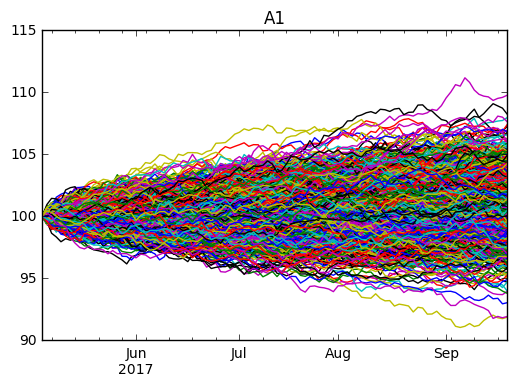

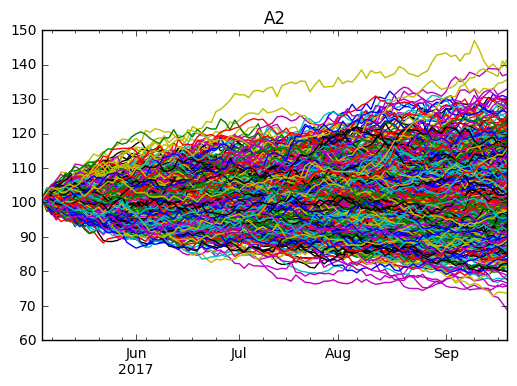

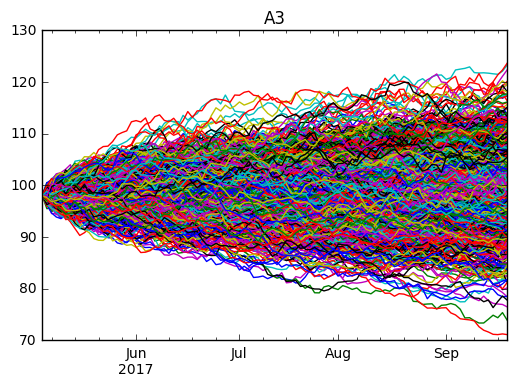

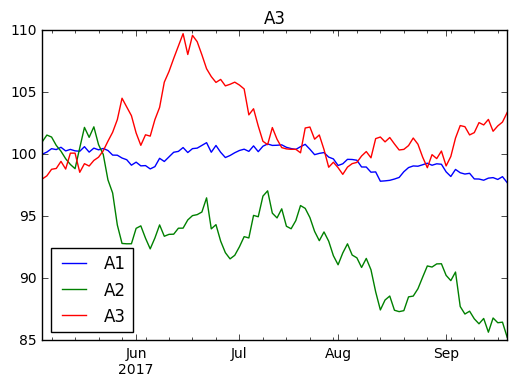

In [374]:
%matplotlib inline 
prices.ix['A1', :,: ].plot(title='A1', legend=False);
prices.ix['A2', :,: ].plot(title='A2', legend=False);
prices.ix['A3', :,: ].plot(title='A3', legend=False);

prices.ix[:, :, 800].plot(title='A3', legend=True);

In [15]:
def EquallyWeightedBasket(optionType,K,numOfSimulations,prices,printer=False):
    sumOptionValue=0.0

    if optionType=="c":
        option=1
    else:
        option=-1
    for i in range(0,numOfSimulations):
        sumOptionValue=max(option*(prices.ix[:, -1, i].mean()-K),0)+sumOptionValue
  
    valueOption=sumOptionValue/numOfSimulations
    
    if printer:
        print "Value of EquallyWeightedBasket :: ", valueOption
    
    return valueOption

EquallyWeightedBasket(optionType="c",K=100,numOfSimulations=numOfSimulations,prices=prices,printer=True)
EquallyWeightedBasket(optionType="p",K=100,numOfSimulations=numOfSimulations,prices=prices,printer=True)

Value of EquallyWeightedBasket ::  1.80054564125
Value of EquallyWeightedBasket ::  1.25032235596


1.2503223559608023

In [16]:
def EuropeanCallOptionAsset(optionType,K,numOfSimulations,prices,assetNum,printer=False):
    sumOptionValue=0.0
    assetID="A"+str(assetNum)
    if optionType=="c":
        option=1
    else:
        option=-1
    for i in range(0,numOfSimulations):
        sumOptionValue=max(option*(prices.ix[assetID, -1,i]-K),0)+sumOptionValue

    
    valueOption=sumOptionValue/numOfSimulations
    if printer:    
        print "Value of EuropeanCallOptionAsset option on Asset " , assetID," :: ", valueOption
    
    return valueOption

EuropeanCallOptionAsset(optionType="c",K=100,numOfSimulations=numOfSimulations,prices=prices,assetNum=2,printer=True)

Value of EuropeanCallOptionAsset option on Asset  A2  ::  5.24955973976


5.249559739758026

In [17]:
def EuropeanPowerOption(optionType,K,numOfSimulations,prices,assetNum,printer=False):
    sumOptionValue=0.0
    assetID="A"+str(assetNum)
    if optionType=="c":
        option=1
    else:
        option=-1
    for i in range(0,numOfSimulations):
        
        sumOptionValue=np.power(max(option*(prices.ix[assetID, -1,i]-K),0),2)+sumOptionValue

         
    valueOption=sumOptionValue/numOfSimulations
    if printer: 
        print "Value of EuropeanPowerOption option on Asset " , assetID," :: ", valueOption
    return valueOption

EuropeanPowerOption(optionType="c",K=100,numOfSimulations=numOfSimulations,prices=prices,assetNum=2,printer=True)

Value of EuropeanPowerOption option on Asset  A2  ::  78.1877539265


78.187753926540196

In [18]:
def EuropeanAsianOption(optionType,K,numOfSimulations,prices,assetNum,printer=False):
    sumOptionValue=0.0
    assetID="A"+str(assetNum)
    if optionType=="c":
        option=1
    else:
        option=-1
    for i in range(0,numOfSimulations):
        averageStockPrice=prices.ix[assetID, :,i ].mean()
        #print prices.ix[i, -1, "A2"],powerStocPrice
        sumOptionValue=max(option*(averageStockPrice-K),0)+sumOptionValue
        
    valueOption=sumOptionValue/numOfSimulations
    if printer: 
        print "Value of EuropeanAsianOption option on Asset " , assetID," :: ", valueOption

    return valueOption
        
EuropeanAsianOption(optionType="c",K=100,numOfSimulations=numOfSimulations,prices=prices,assetNum=2,printer=True)

Value of EuropeanAsianOption option on Asset  A2  ::  3.19259239516


3.1925923951640893

In [20]:
barrier=104
optionType="c"
strike=100


sumOptionValue=0
for i in range(0,numOfSimulations):
    if((prices.ix["A2", :, i]>barrier).any()):
        sumOptionValue=sumOptionValue+EuropeanCallOptionAsset(optionType=optionType,K=strike,numOfSimulations=numOfSimulations,prices=prices,assetNum=2)
    elif( prices.ix["A2", :, i].max() > prices.ix["A3", :, i].max() ):
        sumOptionValue=sumOptionValue+EuropeanPowerOption(optionType=optionType,K=strike,numOfSimulations=numOfSimulations,prices=prices,assetNum=2)
    elif( prices.ix["A2", :, i].mean() > prices.ix["A3", :, i].mean() ):
        sumOptionValue=sumOptionValue+EuropeanAsianOption(optionType=optionType,K=strike,numOfSimulations=numOfSimulations,prices=prices,assetNum=2)
    else:
        sumOptionValue=sumOptionValue+EquallyWeightedBasket(optionType=optionType,K=strike,numOfSimulations=numOfSimulations,prices=prices)

exoticOptionValue=sumOptionValue/numOfSimulations
print "Value of Complex Exotic option :: ",exoticOptionValue

Value of Complex Exotic option ::  8.18881884389


In [363]:
prices.ix["A2", :, :].to_csv('Test.csv') 